# Double asperity simulations

In the previous tutorial, we looked at a rather simple configuration, that of a single asperity which exhibited repetitive, stable limit cycles. In this tutorial, we'll consider a fault with two asperities, one of size $f L_a$, and another of size $(1-f)L_a$. We begin with $f = 0.5$, meaning that both asperities are of equal size $0.5 L_a$. Later on, we can tune this parameter $f$ to see how the behaviour changes.

In [1]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

# Add QDYN source directory to PATH
base_dir = os.path.expanduser("~")
qdyn_dir = os.path.join(base_dir, "qdyn", "qdyn")
plot_dir = os.path.join(qdyn_dir, "utils", "post_processing")
sys.path.append(qdyn_dir)
sys.path.append(plot_dir)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn
import plot_functions as qdyn_plot

We prepare the simulation in a similar way as we have done in the single asperity case:

In [2]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # seconds per year
f = 0.5                     # Size ratio of asperities
L = 15                      # Length of fault / nucleation length
ab_ratio = 0.8              # a/b of asperity
cab_ratio = 1 - ab_ratio
resolution = 7              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 1         # Finite fault
set_dict["TMAX"] = 25*t_yr     # Maximum simulation time [s]
set_dict["NTOUT_OT"] = 10      # Temporal interval (number of time steps) for time series output
set_dict["NTOUT_OX"] = 100     # Temporal interval (number of time steps) for snapshot output
set_dict["NXOUT_OX"] = 2       # Spatial interval (number of elements in x-direction) for snapshot output
set_dict["V_PL"] = 1e-9        # Plate velocity [m/s]
set_dict["MU"] = 3e10          # Shear modulus [Pa]
set_dict["SIGMA"] = 1e8        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 1.2e-2    # Direct effect
set_dict["SET_DICT_RSF"]["B"] = 1e-2      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 4e-4     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]
set_dict["SET_DICT_RSF"]["V_0"] = 0.99 * set_dict["V_PL"]    # Initial slip rate [m/s]

# Compute relevant length scales:
# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
# Nucleation length [m]
Lc = Lb / cab_ratio
# Fault length [m]
L *= Lc
L1 = 0.5 * f * L
L2 = 0.5 * (1 - f) * L
p1 = L / 3 - L / 2
p2 = 2 * L / 3 - L / 2

# Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)
asp1 = (x > (p1 - L1 / 2)) & (x < (p1 + L1 / 2))
asp2 = (x > (p2 - L2 / 2)) & (x < (p2 + L2 / 2))

# Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
# Location on the fault (middle) for time series output
set_dict["IC"] = N // 2

# Output the asperity centers as time series outputs
set_dict["IOT"] = np.zeros(N)
set_dict["IOT"][int(p1/L*N)] = 1
set_dict["IOT"][int(p2/L*N)] = 1

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
p.mesh_dict["A"][asp1 + asp2] = ab_ratio * p.mesh_dict["B"][asp1 + asp2]

# Write input to qdyn.in
p.write_input()
p.W10_bash = False

We can visualise the two asperities by plotting $(a-b)$ versus position on the fault:

<IPython.core.display.Javascript object>


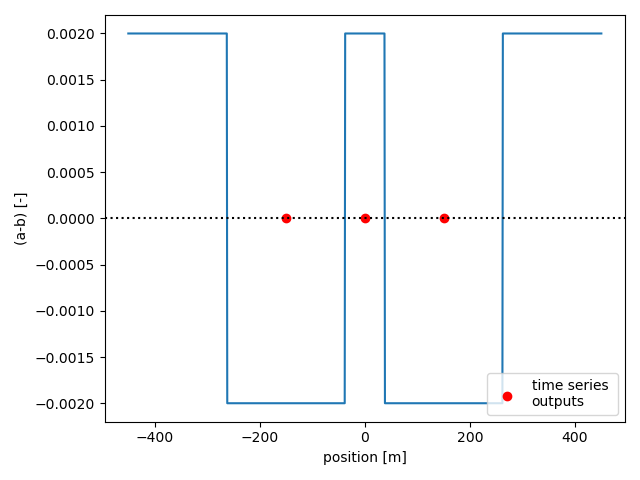

In [3]:
plt.clf()
plt.plot(x, p.mesh_dict["A"] - p.mesh_dict["B"])
plt.scatter([p1,p2,0], [0,0,0], color = 'red', label = 'time series \noutputs')
plt.axhline(0, ls=":", c="k")
plt.xlabel("position [m]")
plt.ylabel("(a-b) [-]")
plt.tight_layout()
plt.legend(loc=4)
plt.show()

We then run this simulation with `p.run()`

In [4]:
# Lets remove if there are output files from previous simulations.
[os.remove(x) for x in os.listdir() if x.startswith('output')]
# Run the simulations
p.run()

True

To get a general impression of how our fault behaved, let's plot the time series of the shear stress $\tau$, state $\theta$ and the slip rate. The locations of time series are the red dots at the above figure.

<IPython.core.display.Javascript object>


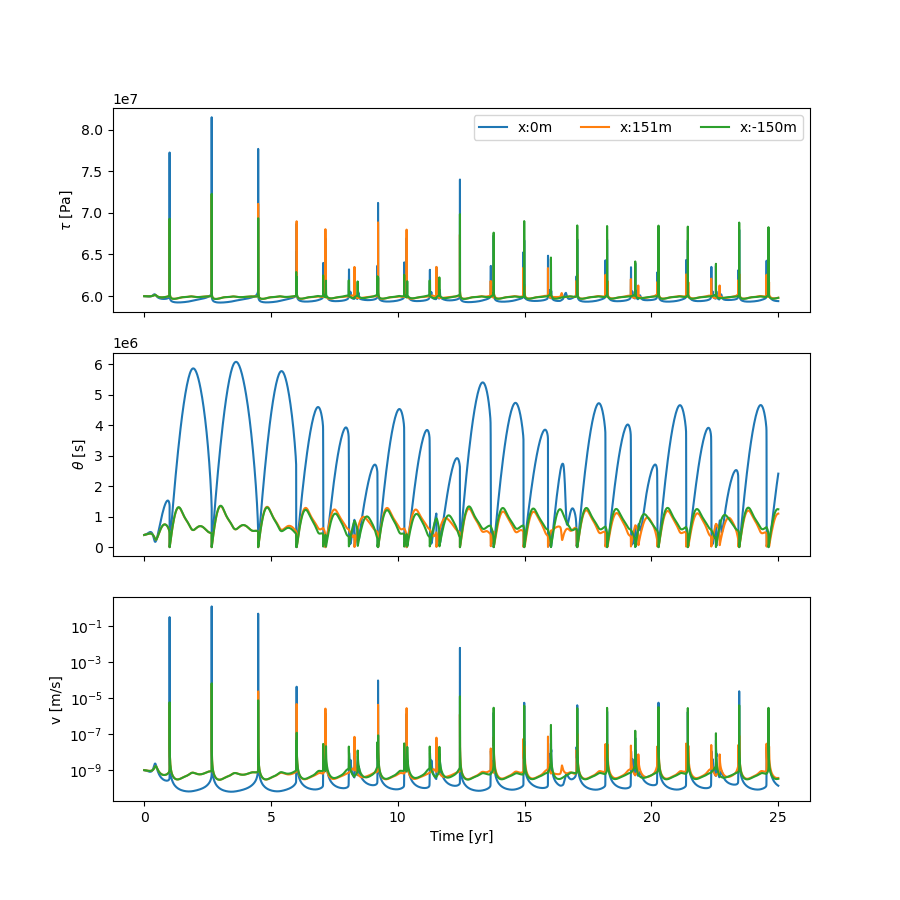

Text(0, 0.5, 'v [m/s]')

In [5]:
# Time series of stress, state, and slip rate on the fault
ot_files = [x for x in os.listdir() if x.startswith('output_ot')]
fig,ax= plt.subplots(3,1, sharex=True, figsize = (9,9))
names=["step","t", "pot", "pot_rate", "v", "theta", "tau", "dtau_dt", "slip", "sigma", "label"]
for ot_file in ot_files:
    df = pd.read_csv(ot_file, delim_whitespace=True, 
                           encoding="utf-8", comment='#')
    df.columns = names  
    xx = x[int(ot_file.split('_')[-1])] / set_dict["NXOUT_OX"]
    ax[0].plot(df['t']/t_yr, df['tau'], label='x:{:.0f}m'.format(xx))
    ax[1].plot(df['t']/t_yr, df['theta'])
    ax[2].semilogy(df['t']/t_yr, df['v'])
    
ax[0].legend(loc=1,ncols=3)
ax[2].set_xlabel('Time [yr]')
ax[0].set_ylabel('$\\tau$ [Pa]')
ax[1].set_ylabel('$\\theta$ [s]')
ax[2].set_ylabel('v [m/s]')

In this double-asperity scenario, we see the opposite of what we saw in the single-asperity case: instead of converging to a stable limit cycle, the earthquake cycles diverge into (deterministic) chaos. This is clearly illustrated by the slip rate evolution:

6


<IPython.core.display.Javascript object>


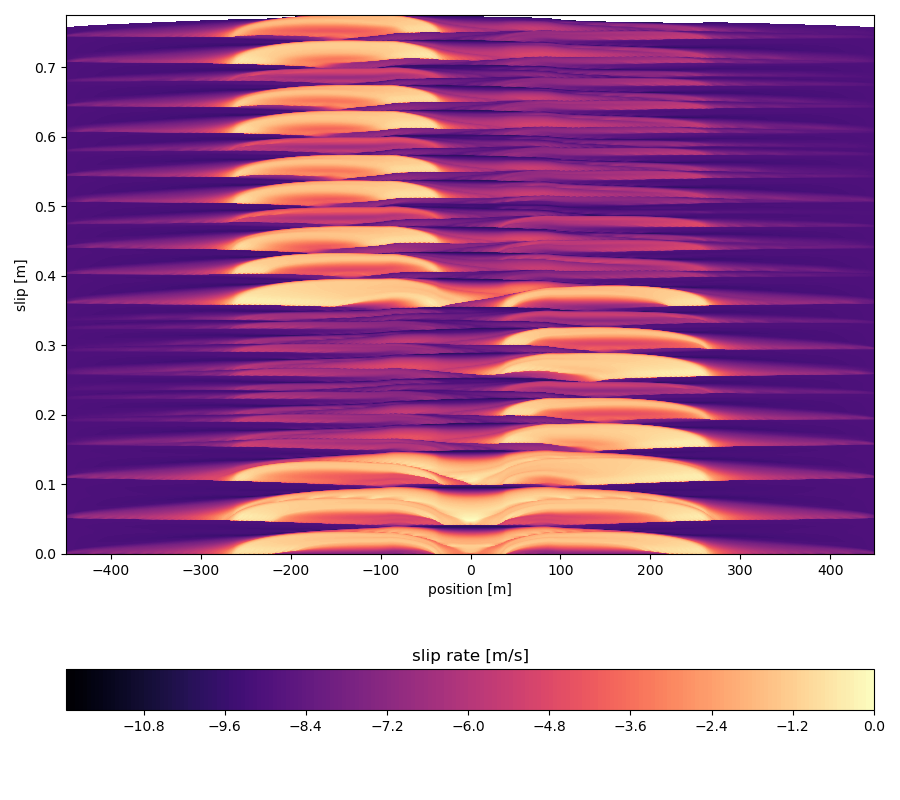

In [6]:
p.read_output()
# Spatio-temporal evolution of slip rates
qdyn_plot.slip_profile(p.ox, warm_up=1*t_yr)

At first, both asperities rupture simultaneously, but after a few cycles, only the right asperity ruptures seismically while the left one mostly creeps. This pattern is reversed after a few more cycles. Lets continue the simualtion with the 'restart' module and see if this pattern continues

In [7]:
set_dict["TMAX"] *= 2     # increase the simulation time twice 

# Repeat the redering mesh and writing input parameters steps
p.settings(set_dict)
p.render_mesh()
p.mesh_dict["A"][asp1 + asp2] = ab_ratio * p.mesh_dict["B"][asp1 + asp2]
p.write_input()
# Run with the restart mode
p.run(restart=True)

True

Let's check the slip profile again. 

6


<IPython.core.display.Javascript object>


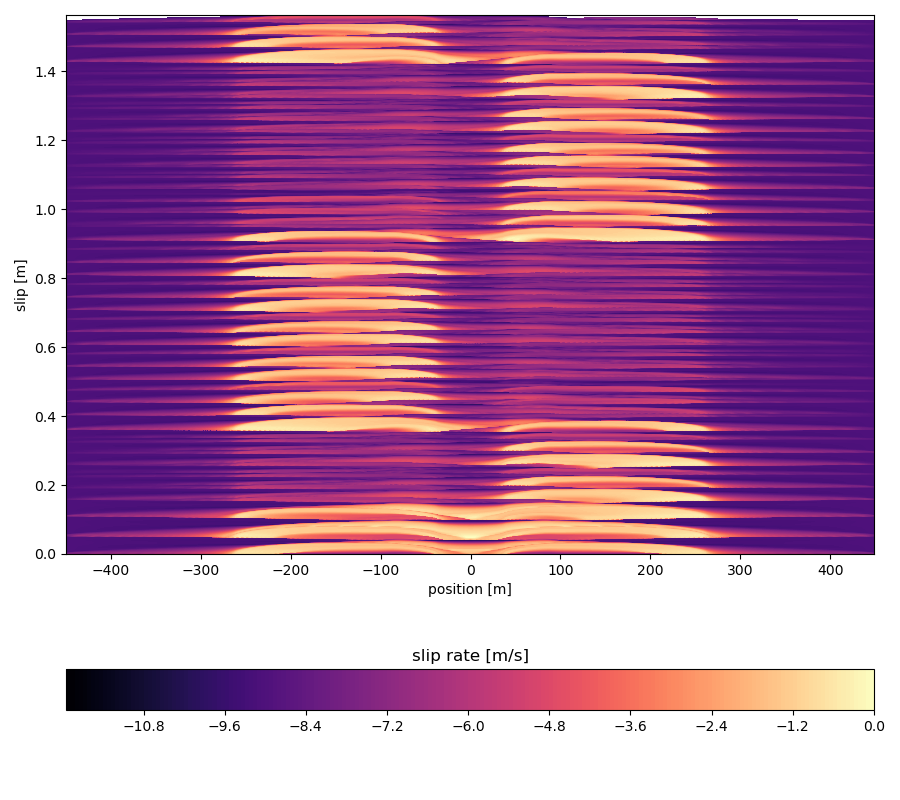

In [8]:
p.read_output()
qdyn_plot.slip_profile(p.ox, warm_up=1*t_yr)

The slip pattern with the extended simulation reveals a switching slip behavior of asperities. When the right asperity generates regular fast earthquakes within a certain interval, the left asperity mostly creeps and generates slow earthquakes. At some point, the slip on one asperity can jump to another, and they can simultaneously generate a larger earthquake. Then, the slip pattern on the asperities switch. Interestingly, this behavior is quasi-periodic. 

## Exercise

Vary `f` to see how the fault's response changes. Why does `f = 0.5` show chaotic behaviour, but not `f = 0.2`? Note that `f = 0.4` is the same as `f = 0.6` (it simply changes the order of the asperities).

In [ ]:
# It is nice to visualize the slip events with an animation.
# But This will take a few minutes...
qdyn_plot.animation_slip(p.ox, warm_up=1*t_yr)